# PRACTICA 3
## Objetivos
1. Veremos otras formas de visualizar el espectro tiempo-frecuencia (TF) muy habituales: el espectrograma y el espectrograma de Mel.
2. Funcionamiento de un detector de actividad vocal (voice activity detector, VAD).

In [13]:
import numpy as np
import librosa as lr
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
import os

from collections import namedtuple
from scipy.fft import rfft, rfftfreq
from scipy.signal import windows

In [14]:
AUDIO_DIR = "audio/"


# named tuple representing a signal
Signal = namedtuple("Signal", ["y", "fs", "file"])


# create a signal from a file
def signal_from_file(filename):
    # read the audio file
    fs, y = wav.read(filename)

    # normalize the signal if it is not already normalized
    # to normalize the signal we divide by the maximum possible value of the data type
    if np.any(abs(y) > 1):
        if np.issubdtype(y.dtype, np.integer):
            y = y / np.iinfo(y.dtype).max
        elif np.issubdtype(y.dtype, np.floating):
            y = y / np.finfo(y.dtype).max
        else:
            raise ValueError("Could not normalize signal")

    return Signal(y, fs, os.path.basename(filename))


# decompose a signal into non overlapping frames
def non_overlapping_frames(signal, frame_duration):
    frame_len = round(frame_duration * signal.fs)
    total_frames = len(signal.y) // frame_len

    frames = signal.y[: total_frames * frame_len]
    frames = frames.reshape(frame_len, total_frames, order="F")

    return frames


# plot signal in continuous time
def plot_signal(y, fs, title, ylabel=None, hline=None, hline_label=None):
    t = np.arange(len(y)) / fs

    plt.plot(t, y)
    plt.xlabel("Time (s)")
    plt.title(title)

    if ylabel:
        plt.ylabel(ylabel)

    if hline:
        hline = plt.axhline(y=hline, color="r", linestyle="--")
        if hline_label:
            plt.legend(handles=[hline], labels=[hline_label])

    plt.show()

## Ejercicio 3.1
Cargamos el archivo de audio y visualizamos su espectrograma de forma similar al ejercicio 2.5 de la segunda práctica.

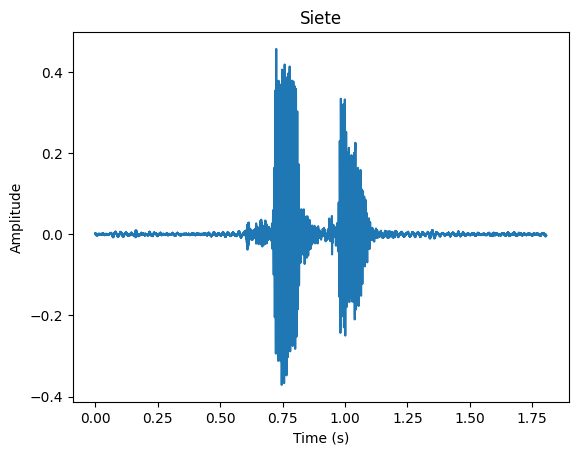

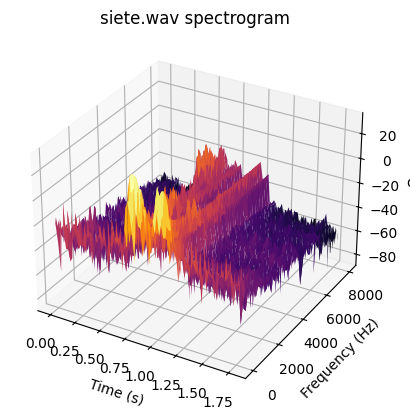

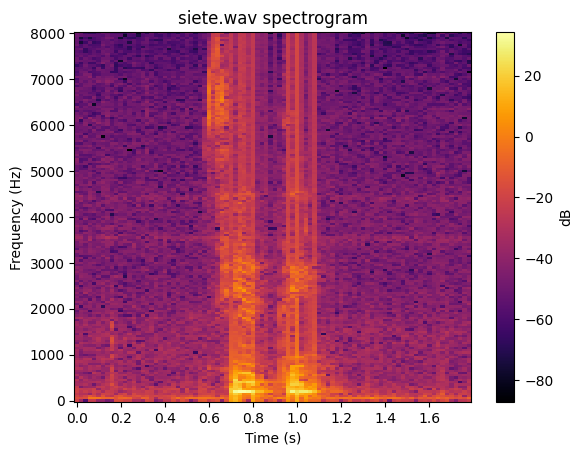

In [15]:
frame_duration = 0.02  # frame duration in seconds

# read the signal from the file
signal = signal_from_file(os.path.join(AUDIO_DIR, "siete.wav"))

# plot the signal
plot_signal(signal.y, signal.fs, "Siete", "Amplitude")

# decompose the signal into non overlapping frames
frames = non_overlapping_frames(signal, frame_duration)
frame_len, total_frames = frames.shape

# compute the fft of the frames
frames_fft = abs(rfft(frames, axis=0))

t = np.arange(total_frames) * frame_duration
f = rfftfreq(frame_len, 1 / signal.fs)
T, F = np.meshgrid(t, f)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot_surface(T, F, 20 * np.log10(frames_fft), cmap="inferno")
ax.set_title(f"{signal.file} spectrogram")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
ax.set_zlabel("dB")
plt.show()

fig, ax = plt.subplots()
pcm = ax.pcolormesh(T, F, 20 * np.log10(frames_fft), cmap="inferno")
ax.set_title(f"{signal.file} spectrogram")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")
fig.colorbar(pcm, label="dB")
plt.show()

## Ejercicio 3.2
En python hay varias posibilidades para representar el espectograma de una señal de manera directa.
En este caso he utilizado la funcion `specgram` de la libreria matplotlib.

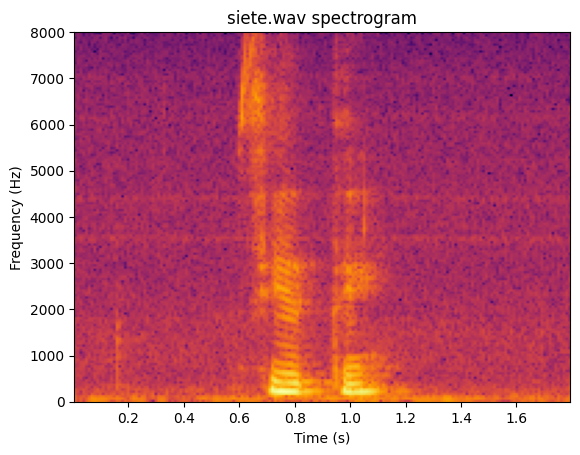

In [16]:
fig, ax = plt.subplots()
ax.set_title(f"{signal.file} spectrogram")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")

_, _, _, im = ax.specgram(
    signal.y,
    Fs=signal.fs,
    NFFT=frame_len,
    noverlap=frame_len // 2,
    mode="magnitude",
    cmap="inferno",
)

## Ejercicio 3.3
Representamos el espectrograma de Mel de la señal.

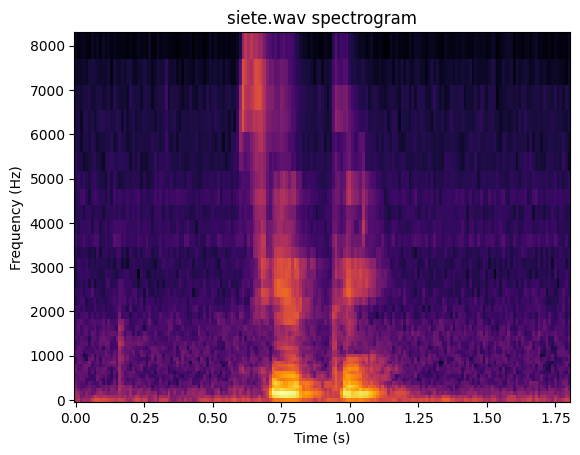

In [17]:
fig, ax = plt.subplots()
ax.set_title(f"{signal.file} spectrogram")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Frequency (Hz)")

# compute the mel spectrogram
mel_spectrogram = lr.feature.melspectrogram(
    y=signal.y,
    sr=signal.fs,
    win_length=frame_len,
    hop_length=frame_len // 2,
    n_mels=40,
)

t = lr.times_like(mel_spectrogram, sr=signal.fs, hop_length=frame_len // 2)
f = lr.mel_frequencies(n_mels=40, fmin=0, fmax=signal.fs / 2)
T, F = np.meshgrid(t, f)

ax.pcolormesh(T, F, 20 * np.log10(mel_spectrogram), cmap="inferno")
fig.colorbar(pcm, label="dB")

plt.show()

## Ejercicio 3.4
Ahora vamos a implementer un VAD (vocal activity detector) sencillo para extraer el contenido de la señal de audio dada.

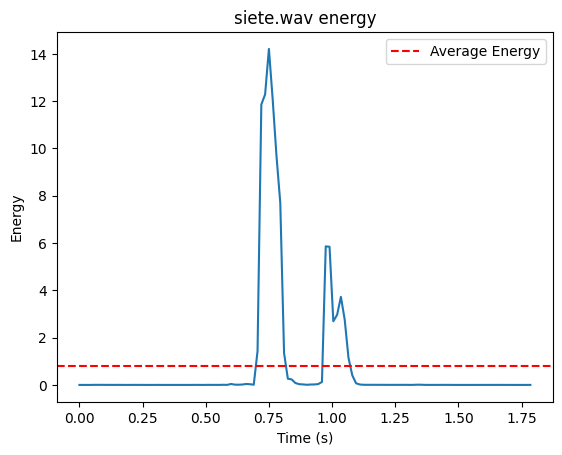

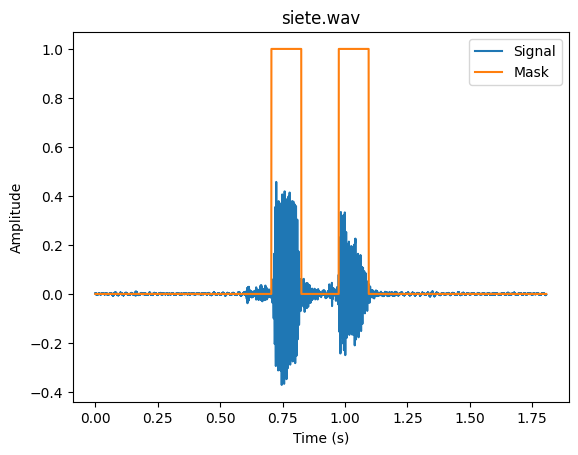

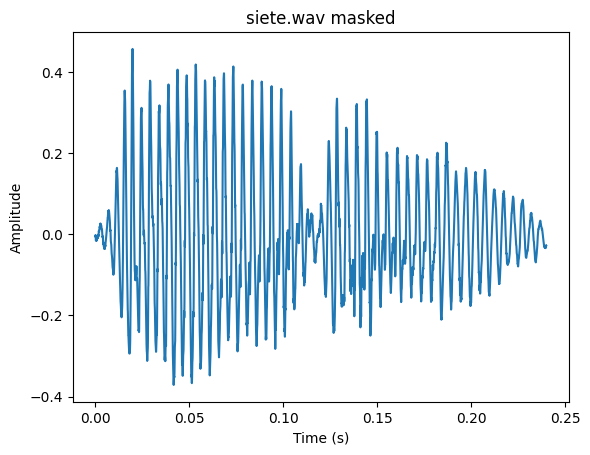

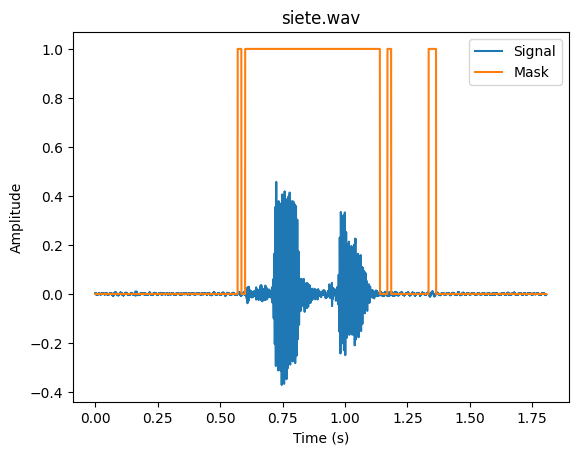

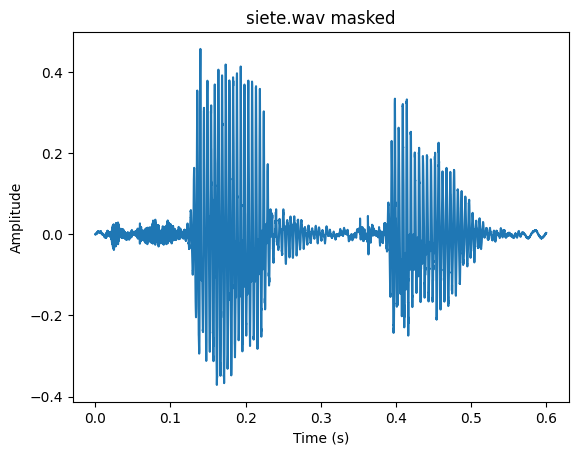

In [18]:
frame_duration = 0.015  # frame duration in seconds

# decompose the signal into non overlapping frames
frames = non_overlapping_frames(signal, frame_duration)

# calculate the energy of the frames and the average energy
energy_frames = np.sum(frames**2, axis=0)
energy_average = np.mean(energy_frames)

# calculate the new sampling frequency
frames_fs = 1 / frame_duration

# plot the energy of the frames with the average energy
plot_signal(
    energy_frames,
    frames_fs,
    f"{signal.file} energy",
    ylabel="Energy",
    hline=energy_average,
    hline_label="Average Energy",
)


threshold_1 = 0.5 * energy_average  # threshold using the average energy
threshold_2 = 5 * np.mean(
    energy_frames[:27]
)  # threshold using the average energy of the first 27 frames

for threshold in [threshold_1, threshold_2]:
    # create a mask for the frames that are above the threshold
    mask = (energy_frames > threshold).astype(int)

    # repeat the mask for each frame
    frame_len = len(frames)
    mask = mask.repeat(frame_len)

    # append zeros to the mask to match the signal length
    mask = np.pad(mask, (0, len(signal.y) - len(mask)))

    # plot the mask and the signal in the same plot
    t = np.arange(len(signal.y)) / signal.fs
    fig, ax = plt.subplots()
    ax.plot(t, signal.y)
    ax.plot(t, mask)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Amplitude")
    ax.set_title(f"{signal.file}")
    ax.legend(labels=["Signal", "Mask"])
    plt.show()

    # plot only the frames that are above the threshold
    y_masked = signal.y[mask > 0]
    plot_signal(y_masked, signal.fs, f"{signal.file} masked", "Amplitude")

    # save the masked signal
    wav.write(
        os.path.join(AUDIO_DIR, "masked_siete.wav"),
        signal.fs,
        (y_masked * 2**15).astype(np.int16),
    )